#1. Installing the libraries and dependencies



In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-cqlbn37h
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-cqlbn37h
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8298 sha256=ba2cc1f6f60821c9886eee8a1aaec61cc34dfd42357289d00fdd0d4877141231
  Stored in directory: /tmp/pip-ephem-wheel-cache-i5pv6pjp/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━

In [ ]:
from keras_vggface.vggface import VGGFace
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import save_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import  Model
from keras.layers import Flatten, Dense, Input, Dropout, Conv2D
from keras_vggface.vggface import VGGFace
import numpy as np
import os
from os import path
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from numpy import asarray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

#2. Setting up the paths and variables

In [ ]:
data_path = '/content/drive/MyDrive/Research_Dataset/Images' #path for dataset
feature_path = '/content/save' #path to save feature vectors
FV_path = '/content/drive/MyDrive/Research_Dataset/Feature_Vectors' #path to load feature vectors from
SS_path = '/content/SSpath' #path to store similarity scores
genuine_path = '/content/SSpath/genuine' #path to store genuine attempts similarity scores
imposter_path = '/content/SSpath/imposter' #path to store genuine imposter similarity scores
aug_path = '/content/aug_images_train' #path to store augmented images
test_path = '/content/test_images' #path to store test images

In [ ]:
face_types = os.listdir(data_path) #represents number of different face types
faces_in_category = list() #list containing number of faces in each face type
genuine_attempts = [list() for i in range(0, len(face_types))] #list of pairs for genuine attempts in each face type
imposter_attempts = [list() for i in range(0, len(face_types))] #list of pairs for imposter attempts in each face type
num_of_genuine_passed = list(tuple()) #list of tuples with each entry representing the number of genuine attempts passed for a particular threshold
num_of_imposter_passed = list(tuple())  #list of tuples with each entry representing the number of imposter attempts passed for a particular threshold
total_genuine_attempts = 0 #total number of genuine attempts
total_imposter_attempts = 0  #total number of imposter attempts
GARs = list(tuple()) #list of tuple containing GAR values for particular threshold
FRRs = list(tuple()) #list of tuple containing FRR values for particular threshold
FARs = list(tuple()) #list of tuple containing FAR values for particular threshold
GRRs = list(tuple()) #list of tuple containing GRR values for particular threshold
FAR_vals = list() #list containing all the FAR values
FRR_vals = list() #list containing all the FRR values
DET_x = list() #x-coordinates for plotting DET graph
DET_y = list() #y-coordinates for plotting DET graph
ROC_x = list() #x-coordinates for plotting ROC graph
ROC_y = list() #y-coordinates for plotting ROC graph
threshold_vals = list() #list of all the possible threshold values
ERR_val = 0 #variable that represents the Equal Error Rate 
imposter_comparisons = list() #list representing the number of imposter comparisons for a particular score
genuine_comparisons = list() #list representing the number of genuine comparisons for a particular score
scores = list() #list of all the possible scores
all_pixels = np.array([32503.7408, 
		23416.5464,
		17355.9432]) #channel-wise sum of pixel values over the train dataset

#3. Test and Train Split

In [ ]:
#preparing data structures for training and test split
X = list(list() for i in range(len(face_types)))
test_data = list(list() for i in range(len(face_types)))
train_data = list(list() for i in range(len(face_types)))

for i in range(0, len(face_types)):
  all_faces = os.listdir(str(data_path + '/' + str(i+1)))
  for j in all_faces:
    X[i].append(j)

In [ ]:
#performing the actual train-test split
for i in range(0, len(face_types)):
  type_X_train, type_X_test = train_test_split(
    X[i], test_size=0.44444444444445, shuffle=True)
  
  for j in type_X_train:
    train_data[i].append(j)

  for j in type_X_test:
    test_data[i].append(j)

In [ ]:
if path.exists(test_path)==False:
  os.mkdir(test_path)

In [ ]:
#saving all the test images
for i in range(0, len(face_types)):

  type_save_dir = test_path + '/' + str(i+1)
  if path.exists(type_save_dir)==False:
    os.mkdir(type_save_dir)

  for j in range(0, len(test_data[i])):

    img_path = data_path + '/' + str(i+1) + '/' + test_data[i][j]
    save_path = type_save_dir + '/' + test_data[i][j]

    img = cv2.imread(img_path)

    cv2.imwrite(save_path, img)

#4. Data Augmentation

In [ ]:
if path.exists(aug_path)==False:
  os.mkdir(aug_path)

In [ ]:
#performing data augmentation and generating 99 more images for every image in training dataset
datagen = ImageDataGenerator(
    rotation_range = 10,
    brightness_range = (0.5, 1.5),
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    rescale = 1./255)

for i in range(0, len(face_types)):

  type_save_dir = aug_path + '/' + str(i+1)
  if path.exists(type_save_dir)==False:
    os.mkdir(type_save_dir)

  for j in range(0, len(train_data[i])):

    print(data_path + '/' +  str(i+1) + '/' + train_data[i][j])
  
    img = cv2.imread(data_path + '/' +  str(i+1) + '/' + train_data[i][j])
    
    x = asarray(img)
    x = x.reshape((1,) + x.shape)

    cv2.imwrite(type_save_dir + '/' + train_data[i][j], img)

    ctr = 1    
    for batch in datagen.flow(x, batch_size=1, save_to_dir=type_save_dir + '/', save_prefix=train_data[i][j] + str(ctr), save_format='jpg'):
      ctr += 1
      if( ctr > 99 ):
        break 

/content/drive/MyDrive/Research_Dataset/Images/1/1-07.jpg
/content/drive/MyDrive/Research_Dataset/Images/1/1-04.jpg
/content/drive/MyDrive/Research_Dataset/Images/1/1-13.jpg
/content/drive/MyDrive/Research_Dataset/Images/1/1-06.jpg
/content/drive/MyDrive/Research_Dataset/Images/2/2-04.jpg
/content/drive/MyDrive/Research_Dataset/Images/2/2-12.jpg
/content/drive/MyDrive/Research_Dataset/Images/2/2-07.jpg
/content/drive/MyDrive/Research_Dataset/Images/2/2-05.jpg
/content/drive/MyDrive/Research_Dataset/Images/3/3-04.jpg
/content/drive/MyDrive/Research_Dataset/Images/3/3-03.jpg
/content/drive/MyDrive/Research_Dataset/Images/3/3-07.jpg
/content/drive/MyDrive/Research_Dataset/Images/3/3-13.jpg
/content/drive/MyDrive/Research_Dataset/Images/4/4-11.jpg
/content/drive/MyDrive/Research_Dataset/Images/4/4-08.jpg
/content/drive/MyDrive/Research_Dataset/Images/4/4-07.jpg
/content/drive/MyDrive/Research_Dataset/Images/4/4-05.jpg
/content/drive/MyDrive/Research_Dataset/Images/5/5-11.jpg
/content/drive

In [ ]:
#calculating the number of training images and obtaining the means
num_aug = 0

for i in range(0, len(face_types)):
  dir_path = aug_path + '/' + str(i+1)
  all_aug_faces = os.listdir(dir_path)

  num_aug += len(all_aug_faces)

print(num_aug)
means = np.divide(all_pixels, num_aug)

79579


#5. Image Pre-processing

In [ ]:
#helper function to change image format to RGB
def convertFormat(img):
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return rgb_img

In [ ]:
#helper function to standardize and then normalize the image
def standardizeImage(img):
  pixels = asarray(img)

  # convert from integers to floats
  pixels = pixels.astype('float32')
  pixels = np.divide(pixels, 255.0)

  # per-channel standardization of pixels
  pixels = pixels - means

  return pixels

In [ ]:
#function for preprocessing the input image
img_size = (224, 224)

def preProcessImage(img):
  
  res_img = cv2.resize(img, img_size) #resizing image to (224, 224)
  rgb_img = convertFormat(res_img) #converting image from BGR to RGB format
  pixels = standardizeImage(rgb_img) #normalize and standardize image
  expanded_img = np.expand_dims(pixels, axis=0) #expanding image dimensions 
  input_array = expanded_img.astype('f') #converting pixel values to float

  return input_array

#6. Custom Model

In [ ]:
#initializing the model
vgg = VGG16(input_shape = [224, 224] + [3], include_top = False)

In [ ]:
#freezing the weights of first 15 layers
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
#fine-tuning the model
last_layer = vgg.get_layer('block5_pool').output


x = Conv2D(4096, (7,7), activation='relu', name='fc6', trainable=False)(last_layer)
x = Conv2D(4096, (1,1), activation='relu', name='fc7', trainable=False)(x)
x = Flatten(name='flatten')(x)
x = Dense(2048, activation='relu', name='fc8')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu', name='fc9')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu', name='fc10')(x)
x = Dropout(0.25)(x)
x = Dense(len(face_types), activation='softmax', name='fc11')(x)
x = Dropout(0.25)(x)

model = Model(vgg.input, x)
model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5', skip_mismatch=True, by_name=True)


In [ ]:
#getting the model summary
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#compiling the model with appropriate optimizer function and metrics
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']
)

#7.Train the model

In [ ]:
#Initializing the training set for the model
train_datagen = ImageDataGenerator(preprocessing_function = preProcessImage)

training_set = train_datagen.flow_from_directory(aug_path,
                                                 target_size = (224,224),
                                                 color_mode = "rgb",
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 79579 images belonging to 200 classes.


In [ ]:
#Initializing the validation set for the model
test_datagen = ImageDataGenerator(preprocessing_function = preProcessImage)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 200 classes.


In [ ]:
#Training the model
r = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs = 100,
    steps_per_epoch = len(training_set),
    validation_steps = 32,
    callbacks = [EarlyStopping(monitor='val_accuracy', verbose = 1, patience=20),
             ModelCheckpoint(filepath='best_model_without_dropout.h5', monitor='val_accuracy', save_best_only=True)]

)

<ipython-input-37-79758fd139d5>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/100
   3/2487 [..............................] - ETA: 14:44:19 - loss: 7.8305 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

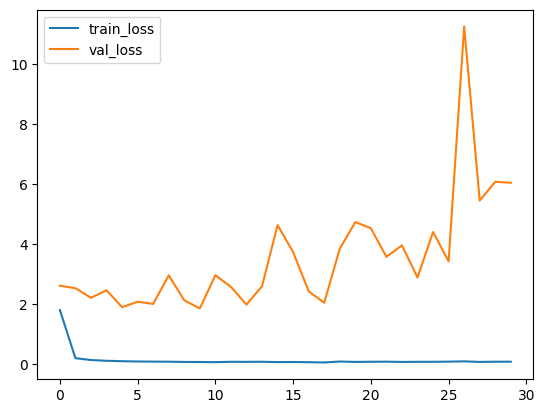

<Figure size 640x480 with 0 Axes>

In [ ]:
#loss plot
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

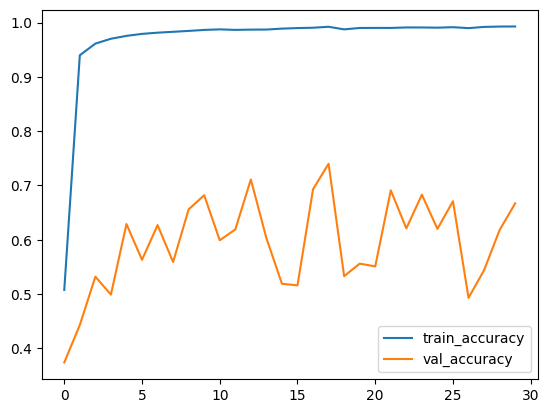

<Figure size 640x480 with 0 Axes>

In [ ]:
#accuracy plot
plt.plot(r.history['accuracy'], label = 'train_accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')